<a href="https://colab.research.google.com/github/nabdelouali/FMCW_Radar/blob/main/FFT_Resolution_N_vs_2N_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

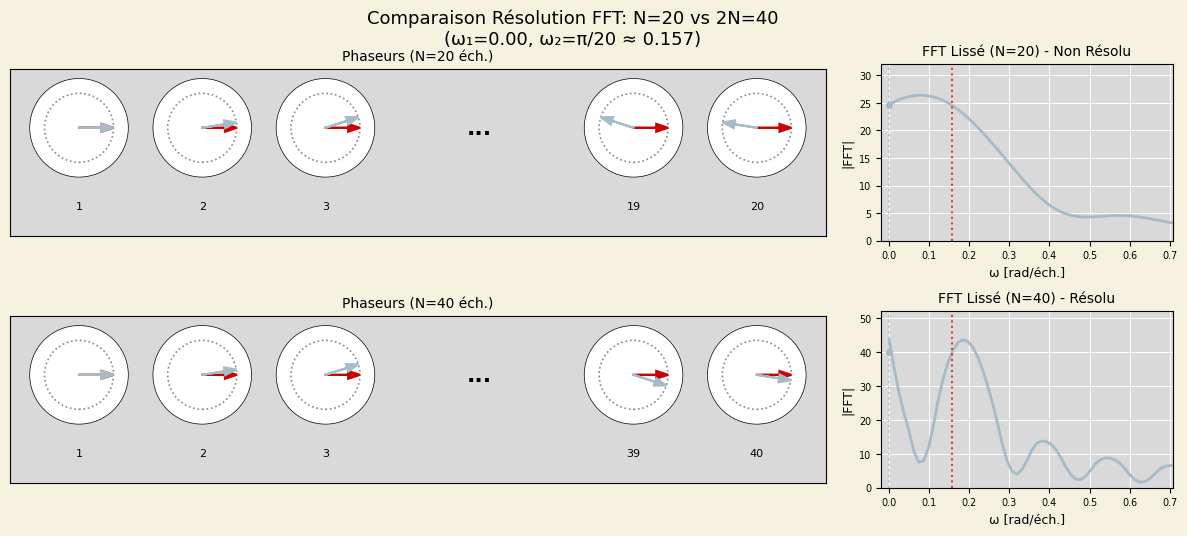

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from matplotlib.gridspec import GridSpec

# ---- Définition de la Palette de Couleurs ----
colors = {
    'black': '#000000', 'yellow': '#F3E079', 'soft_grey': '#D9D9D9',
    'muted_blue': '#A7BBC7', 'red_ti': '#CC0000', 'light_green': '#C7E5A6',
    'white': '#FFFFFF', 'beige': '#F5F2E0'
}

# ---- Paramètres des Scénarios de Résolution ----
N_scenario = 20
N_scenario_doubled = 2 * N_scenario

A1 = 1.0
omega1 = 0.0
omega2 = np.pi / N_scenario
A2 = 1.0
FFT_LENGTH = 512

# ---- Création de la Figure et des Axes avec GridSpec ----
fig = plt.figure(figsize=(15, 5.5))
fig.patch.set_facecolor(colors['beige'])
fig.suptitle(f"Comparaison Résolution FFT: N={N_scenario} vs 2N={N_scenario_doubled}\n"
             f"(ω₁={omega1:.2f}, ω₂=π/{N_scenario} ≈ {omega2:.3f})",
             fontsize=13, color=colors['black'])

main_gs = fig.add_gridspec(2, 1, hspace=0.4)
gs_top = main_gs[0].subgridspec(1, 2, width_ratios=[2.8, 1], wspace=0.1)
gs_bottom = main_gs[1].subgridspec(1, 2, width_ratios=[2.8, 1], wspace=0.1)

axs = [
    [fig.add_subplot(gs_top[0]), fig.add_subplot(gs_top[1])],
    [fig.add_subplot(gs_bottom[0]), fig.add_subplot(gs_bottom[1])]
]

# Fonction pour dessiner la SÉQUENCE d'instantanés des phaseurs
def plot_phasor_sequence(ax, N_total_in_sequence, k_indices_to_show_relative, title_suffix):
    ax.set_facecolor(colors['soft_grey'])
    ax.set_aspect('equal')
    num_circles_to_draw = len(k_indices_to_show_relative)
    circle_radius = 0.5
    base_spacing_factor = 2.5 * circle_radius
    ellipsis_spacing_factor = 2.5 * base_spacing_factor
    current_x_offset = 0
    centers_x = []
    has_ellipsis = False
    for i in range(num_circles_to_draw):
        centers_x.append(current_x_offset)
        if num_circles_to_draw > 3 and i == 2:
            current_x_offset += ellipsis_spacing_factor
            has_ellipsis = True
        else:
            current_x_offset += base_spacing_factor
    total_width_needed = centers_x[-1] + circle_radius
    ax.set_xlim(-circle_radius - 0.2, total_width_needed + 0.2)
    ax.set_ylim(-circle_radius * 2.2, circle_radius * 1.2)
    ax.set_title(f"Phaseurs ({title_suffix})", color=colors['black'], fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])
    # MODIFICATION: Changed border color to black
    for spine in ax.spines.values(): spine.set_edgecolor(colors['black'])

    for i, k_rel in enumerate(k_indices_to_show_relative):
        if k_rel == 'N-2': k_actual = N_total_in_sequence - 2
        elif k_rel == 'N-1': k_actual = N_total_in_sequence - 1
        else: k_actual = k_rel
        if k_actual < 0 or k_actual >= N_total_in_sequence: continue

        center_x = centers_x[i]
        circle = plt.Circle((center_x, 0), circle_radius, color=colors['white'], ec=colors['black'], lw=0.5, zorder=1)
        ax.add_artist(circle)

        arrow_scale_factor = circle_radius * 0.7

        guide_circle = plt.Circle((center_x, 0), arrow_scale_factor,
                                  facecolor='none', ec='#888888', ls='dotted', lw=1.2, zorder=1.5)
        ax.add_artist(guide_circle)

        # Draw stationary RED phasor (ph1)
        ph1_complex = A1 * np.exp(1j * omega1 * k_actual)
        ph1_norm_factor = A1 if A1 != 0 else 1
        ax.arrow(center_x, 0, ph1_complex.real * (arrow_scale_factor / ph1_norm_factor), ph1_complex.imag * (arrow_scale_factor / ph1_norm_factor),
                 head_width=0.08, head_length=0.12, fc=colors['red_ti'], ec=colors['red_ti'], lw=1.5, zorder=2, length_includes_head=True)

        # Draw rotating BLUE phasor (ph2)
        ph2_complex = A2 * np.exp(1j * omega2 * k_actual)
        ph2_norm_factor = A2 if A2 != 0 else 1
        ax.arrow(center_x, 0, ph2_complex.real * (arrow_scale_factor / ph2_norm_factor), ph2_complex.imag * (arrow_scale_factor / ph2_norm_factor),
                 head_width=0.08, head_length=0.12, fc=colors['muted_blue'], ec=colors['muted_blue'], lw=1.5, zorder=2, length_includes_head=True)

        label_k_text = ""
        if isinstance(k_rel, int): label_k_text = str(k_actual + 1)
        elif k_rel == 'N-2': label_k_text = str(N_total_in_sequence - 1)
        elif k_rel == 'N-1': label_k_text = str(N_total_in_sequence)

        if has_ellipsis and i == 2:
             ellipsis_x_pos = (centers_x[i] + centers_x[i+1]) / 2
             ax.text(ellipsis_x_pos, 0, "...", ha='center', va='center', fontsize=16,
                     color=colors['black'], fontweight='bold')

        ax.text(center_x, -circle_radius * 1.6, label_k_text, ha='center', va='center', fontsize=8, color=colors['black'])

# Fonction pour lisser le spectre FFT (identique)
def smooth_fft(fft_magnitude, window_length=11, polyorder=2):
    if len(fft_magnitude) < window_length: return fft_magnitude
    window_length = min(window_length, len(fft_magnitude))
    if window_length % 2 == 0: window_length -= 1
    if window_length < polyorder + 1 or window_length < 3 : return fft_magnitude
    try: return savgol_filter(fft_magnitude, window_length, polyorder, mode='interp')
    except ValueError: return fft_magnitude

# --- SCÉNARIO 1: N échantillons ---
k_indices_N_relative = [0, 1, 2, 'N-2', 'N-1']
plot_phasor_sequence(axs[0][0], N_scenario, k_indices_N_relative, f"N={N_scenario} éch.")

k_values_N = np.arange(N_scenario)
signal_complex_N_full = A1 * np.exp(1j * omega1 * k_values_N) + A2 * np.exp(1j * omega2 * k_values_N)
fft_result_N = np.fft.fft(signal_complex_N_full, n=FFT_LENGTH)
fft_magnitude_N_raw = np.abs(fft_result_N)
fft_freq_axis = np.fft.rfftfreq(FFT_LENGTH, d=1.0) * 2 * np.pi
fft_to_plot_N_raw = fft_magnitude_N_raw[:len(fft_freq_axis)]
smooth_window_N = max(5, int(FFT_LENGTH / (N_scenario * 1.2)) | 1)
fft_to_plot_N_smooth = smooth_fft(fft_to_plot_N_raw, window_length=smooth_window_N, polyorder=2)

ax = axs[0][1]
ax.set_facecolor(colors['soft_grey'])
ax.plot(fft_freq_axis, fft_to_plot_N_smooth, color=colors['muted_blue'], lw=2.0)
if omega1 == 0 and fft_to_plot_N_raw.size > 0 :
    ax.plot(fft_freq_axis[0], fft_to_plot_N_raw[0], 'o', color=colors['muted_blue'], markersize=4)
ax.set_title(f"FFT Lissé (N={N_scenario}) - Non Résolu", color=colors['black'], fontsize=10)
ax.set_xlabel("ω [rad/éch.]", fontsize=9); ax.set_ylabel("|FFT|", fontsize=9)
ax.set_xlim(-0.02, omega2 * 4.5)
ax.set_ylim(0, 32)
ax.set_yticks(np.arange(0, 31, 5))
ax.grid(True, color=colors['white'], linestyle='-', linewidth=0.7)
ax.axvline(omega1, color=colors['muted_blue'], linestyle=':', alpha=0.7); ax.axvline(omega2, color=colors['red_ti'], linestyle=':', alpha=0.7)
ax.tick_params(axis='both', colors=colors['black'], labelsize='x-small')
# MODIFICATION: Changed border color to black
for spine in ax.spines.values(): spine.set_edgecolor(colors['black'])

# --- SCÉNARIO 2: 2N échantillons ---
k_indices_2N_relative = [0, 1, 2, 'N-2', 'N-1']
plot_phasor_sequence(axs[1][0], N_scenario_doubled, k_indices_2N_relative, f"N={N_scenario_doubled} éch.")

k_values_2N = np.arange(N_scenario_doubled)
signal_complex_2N_full = A1 * np.exp(1j * omega1 * k_values_2N) + A2 * np.exp(1j * omega2 * k_values_2N)
fft_result_2N = np.fft.fft(signal_complex_2N_full, n=FFT_LENGTH)
fft_magnitude_2N_raw = np.abs(fft_result_2N)
fft_to_plot_2N_raw = fft_magnitude_2N_raw[:len(fft_freq_axis)]
smooth_window_2N = max(5, int(FFT_LENGTH / (N_scenario_doubled * 1.5)) | 1)
fft_to_plot_2N_smooth = smooth_fft(fft_to_plot_2N_raw, window_length=smooth_window_2N, polyorder=2)

ax = axs[1][1]
ax.set_facecolor(colors['soft_grey'])
ax.plot(fft_freq_axis, fft_to_plot_2N_smooth, color=colors['muted_blue'], lw=2.0)
if omega1 == 0 and fft_to_plot_2N_raw.size > 0:
    ax.plot(fft_freq_axis[0], fft_to_plot_2N_raw[0], 'o', color=colors['muted_blue'], markersize=4)
ax.set_title(f"FFT Lissé (N={N_scenario_doubled}) - Résolu", color=colors['black'], fontsize=10)
ax.set_xlabel("ω [rad/éch.]", fontsize=9); ax.set_ylabel("|FFT|", fontsize=9)
ax.set_xlim(-0.02, omega2 * 4.5)
ax.set_ylim(0, 52)
ax.set_yticks(np.arange(0, 51, 10))
ax.grid(True, color=colors['white'], linestyle='-', linewidth=0.7)
ax.axvline(omega1, color=colors['muted_blue'], linestyle=':', alpha=0.7); ax.axvline(omega2, color=colors['red_ti'], linestyle=':', alpha=0.7)
ax.tick_params(axis='both', colors=colors['black'], labelsize='x-small')
# MODIFICATION: Changed border color to black
for spine in ax.spines.values(): spine.set_edgecolor(colors['black'])

# fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()